In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import filters
import cv2
from scipy.ndimage import gaussian_filter
from scipy import ndimage

# import tensorflow as tf
import copy

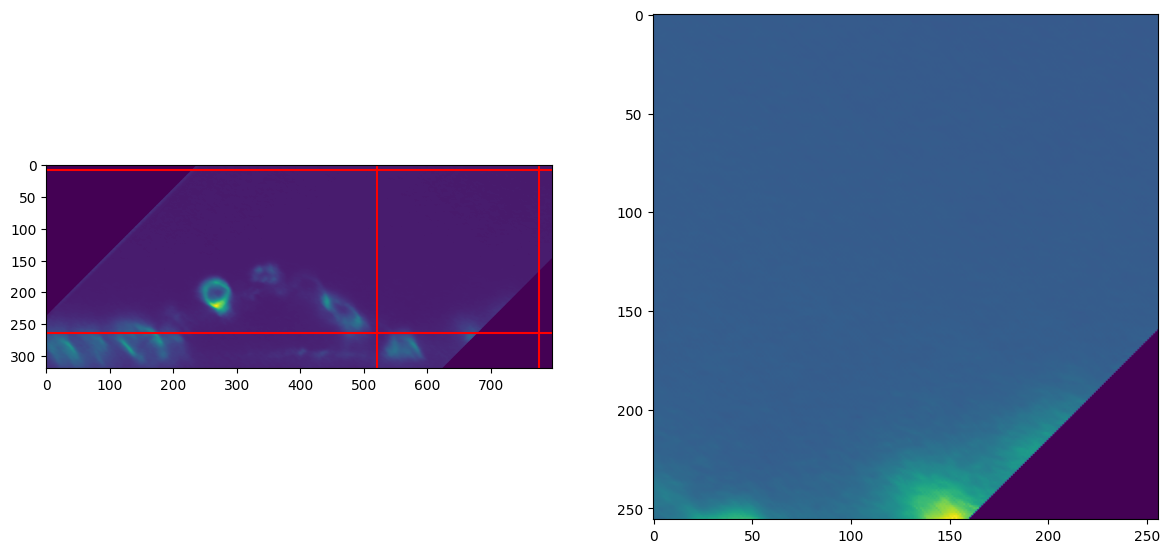

In [89]:
# image = sk.io.imread('./domes/Dome103_processed_n2v2d.tif')
image = sk.io.imread('./../test_domes/Dome103_processed_n2v2d.tif')
image = np.transpose(image, axes=(1, 0, 2))

# viewer = napari.Viewer()
# viewer.add_image(image)
# alpha = 1  # Adjust this value to change contrast
# beta = 1   # Adjust this value to change brightness
# image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
# viewer.add_image(image)

z = 100

y1, y2 = 8, 264
x1, x2 = 424, 680

y1, y2 = 100, 228
x1, x2 = 150, 278

y1, y2 = 8, 264
x1, x2 = 520, 520+256


plt.figure(figsize=(30,7))

plt.subplot(1,4,1)
plt.imshow(image[z])
plt.axhline(y1, c='r')
plt.axhline(y2, c='r')
plt.axvline(x1, c='r')
plt.axvline(x2, c='r')

plt.subplot(1,4,2)

im = image[z, y1:y2, x1:x2]
plt.imshow(im)

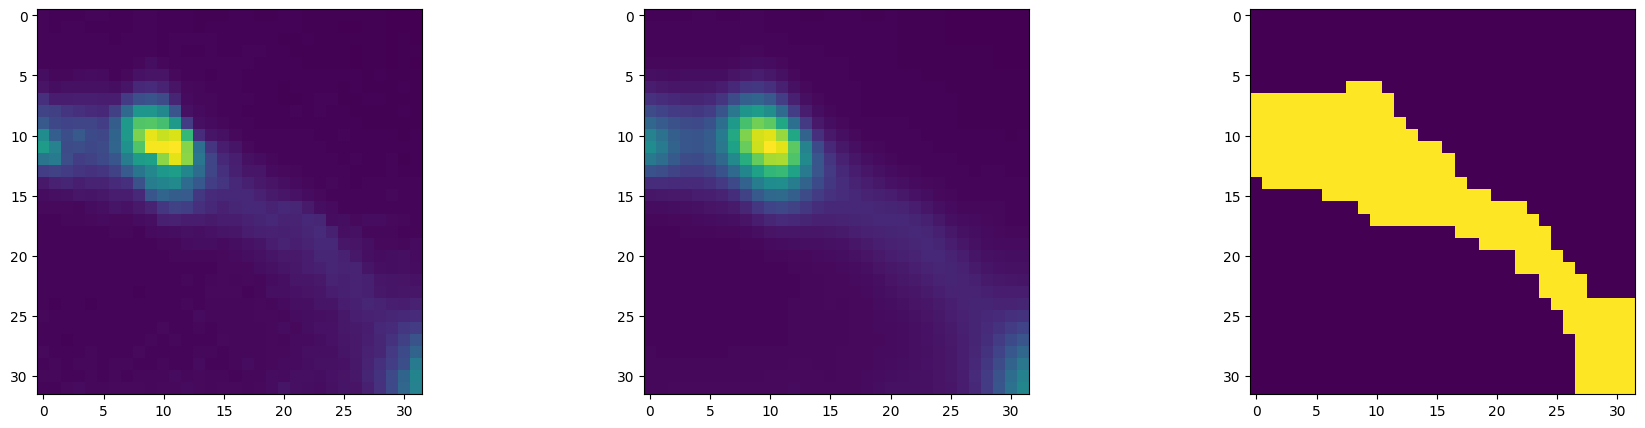

In [15]:
pool_size = (2, 2)
pooled_image = sk.measure.block_reduce(im, pool_size, func=np.max)
pooled_image = sk.measure.block_reduce(pooled_image, pool_size, func=np.max)
pooled_image = sk.measure.block_reduce(pooled_image, pool_size, func=np.max)
# pooled_image = sk.measure.block_reduce(pooled_image, pool_size, func=np.max)
# pooled_image = sk.measure.block_reduce(pooled_image, pool_size, func=np.max)

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(pooled_image)


plt.subplot(1,4,2)
pooled_image_g = gaussian_filter(pooled_image, sigma=1)
plt.imshow(pooled_image_g)


plt.subplot(1,4,3)
mean =  pooled_image.mean()
pooled_mask = copy.copy(pooled_image)
pooled_mask[pooled_image > mean] = 255
pooled_mask[pooled_image <= mean] = 0

plt.imshow(pooled_mask)

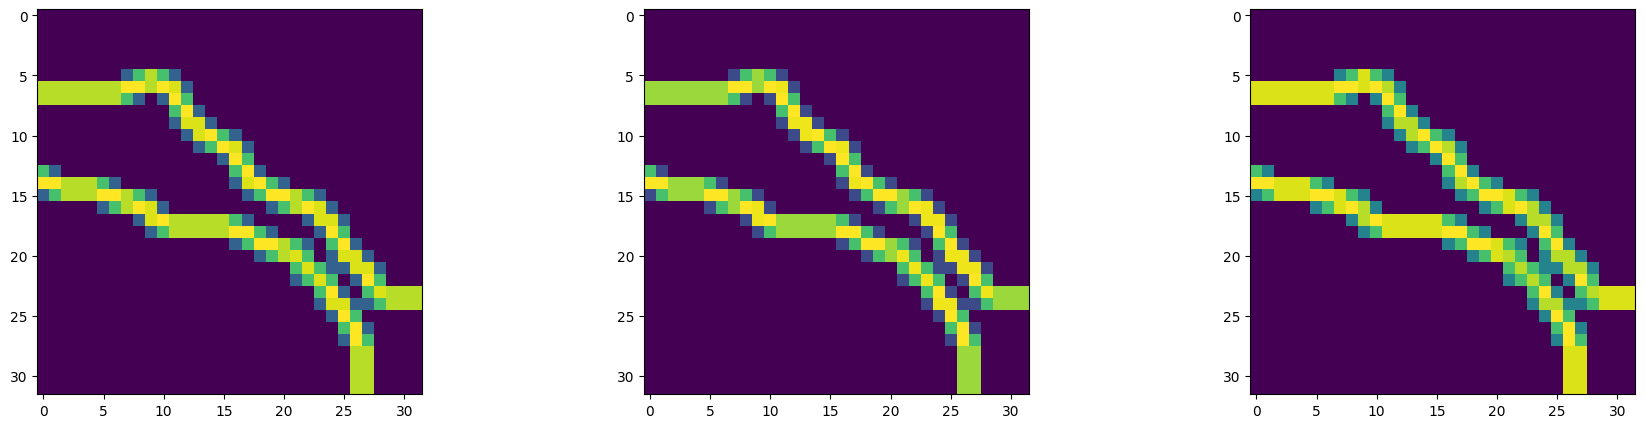

In [16]:
edge_sobel = filters.sobel(pooled_mask)
edge_scharr = filters.scharr(pooled_mask)
edge_prewitt = filters.prewitt(pooled_mask)

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(edge_sobel)
plt.subplot(1,4,2)
plt.imshow(edge_scharr)
plt.subplot(1,4,3)
plt.imshow(edge_prewitt)

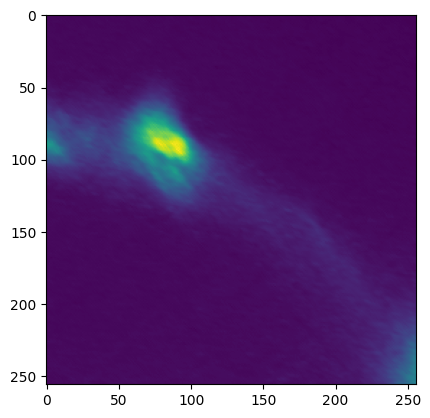

In [17]:
plt.imshow(im)

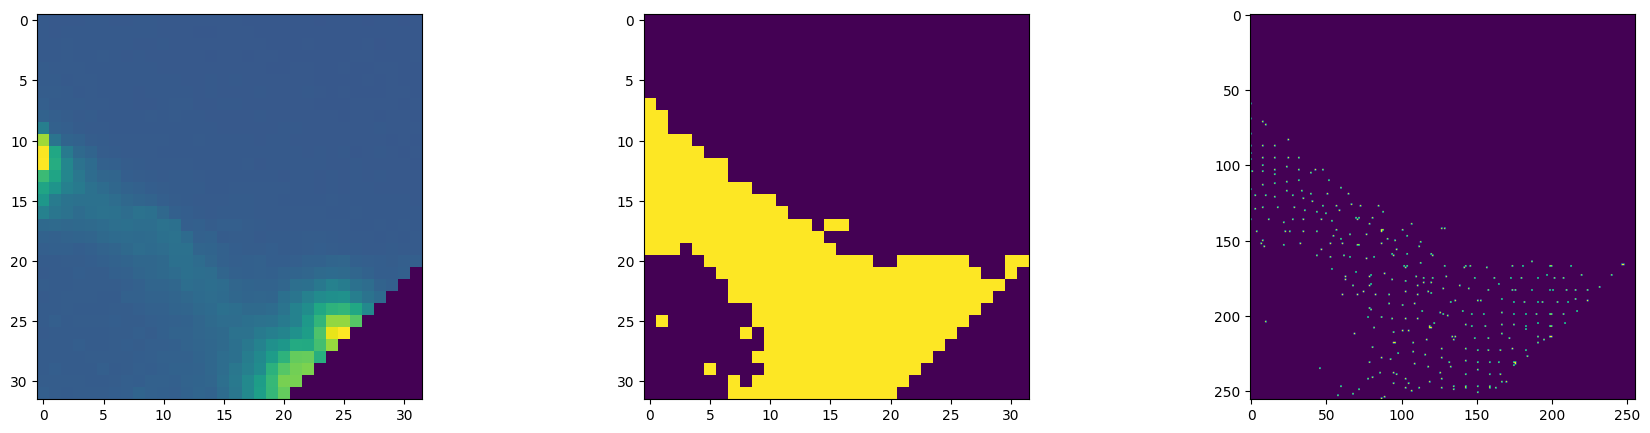

In [13]:
def poolAndMax(input, pool=(2,2)):
    shapeY, shapeX = input.shape[0], input.shape[1]
    newY, newX = int(shapeY/2), int(shapeX/2)
    # print(shapeY, shapeX, newY, newX)
    poolList = []
    maxList = [[0 for _ in range(newY)] for _ in range(newX)]
    for y in range(0, shapeY, pool[0]):
        for x in range(0, shapeX, pool[1]):
            patch = input[y:y+pool[0], x:x+pool[1]]
            poolList.append(patch.max())
            # maxList.append(np.where(patch == patch.max()))
            # maxList[int(y/2)][int(x/2)] = np.where(patch == patch.max())
            
            indices = np.unravel_index(np.argmax(patch), patch.shape)
            maxList[int(y / pool[0])][int(x / pool[1])] = (y + indices[0], x + indices[1])
            
    poolArray = np.array(poolList)
    poolArray = np.reshape(poolArray, (newY, newX))
    maxList = np.array(maxList)
    
    return poolArray, maxList

def deconv(input, maxList, pool=(2,2)):
    shapeY, shapeX = input.shape[0], input.shape[1]
    newY, newX = int(shapeY*2), int(shapeX*2)
    # print(shapeY, shapeX, newY, newX)
    
    output = [[0 for _ in range(newY)] for _ in range(newX)]
    
    for y in range(0, shapeY):
        for x in range(0, shapeX):
            indices = maxList[y, x]
            output[indices[0]][indices[1]] = input[y, x]
    
    output = np.array(output)
    return output
            
    
        
plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
pool1, maxList1 = poolAndMax(im)
pool2, maxList2 = poolAndMax(pool1)
pool3, maxList3 = poolAndMax(pool2)
plt.imshow(pool3)

mean =  pool3.mean()
pooled_mask = copy.copy(pool3)
pooled_mask[pool3 > mean] = 255
pooled_mask[pool3 <= mean] = 0

plt.subplot(1,4,2)
plt.imshow(pooled_mask)


plt.subplot(1,4,3)

deconv1 = deconv(pooled_mask, maxList3)
deconv2 = deconv(deconv1, maxList2)
deconv3 = deconv(deconv2, maxList1)


plt.imshow(deconv3)



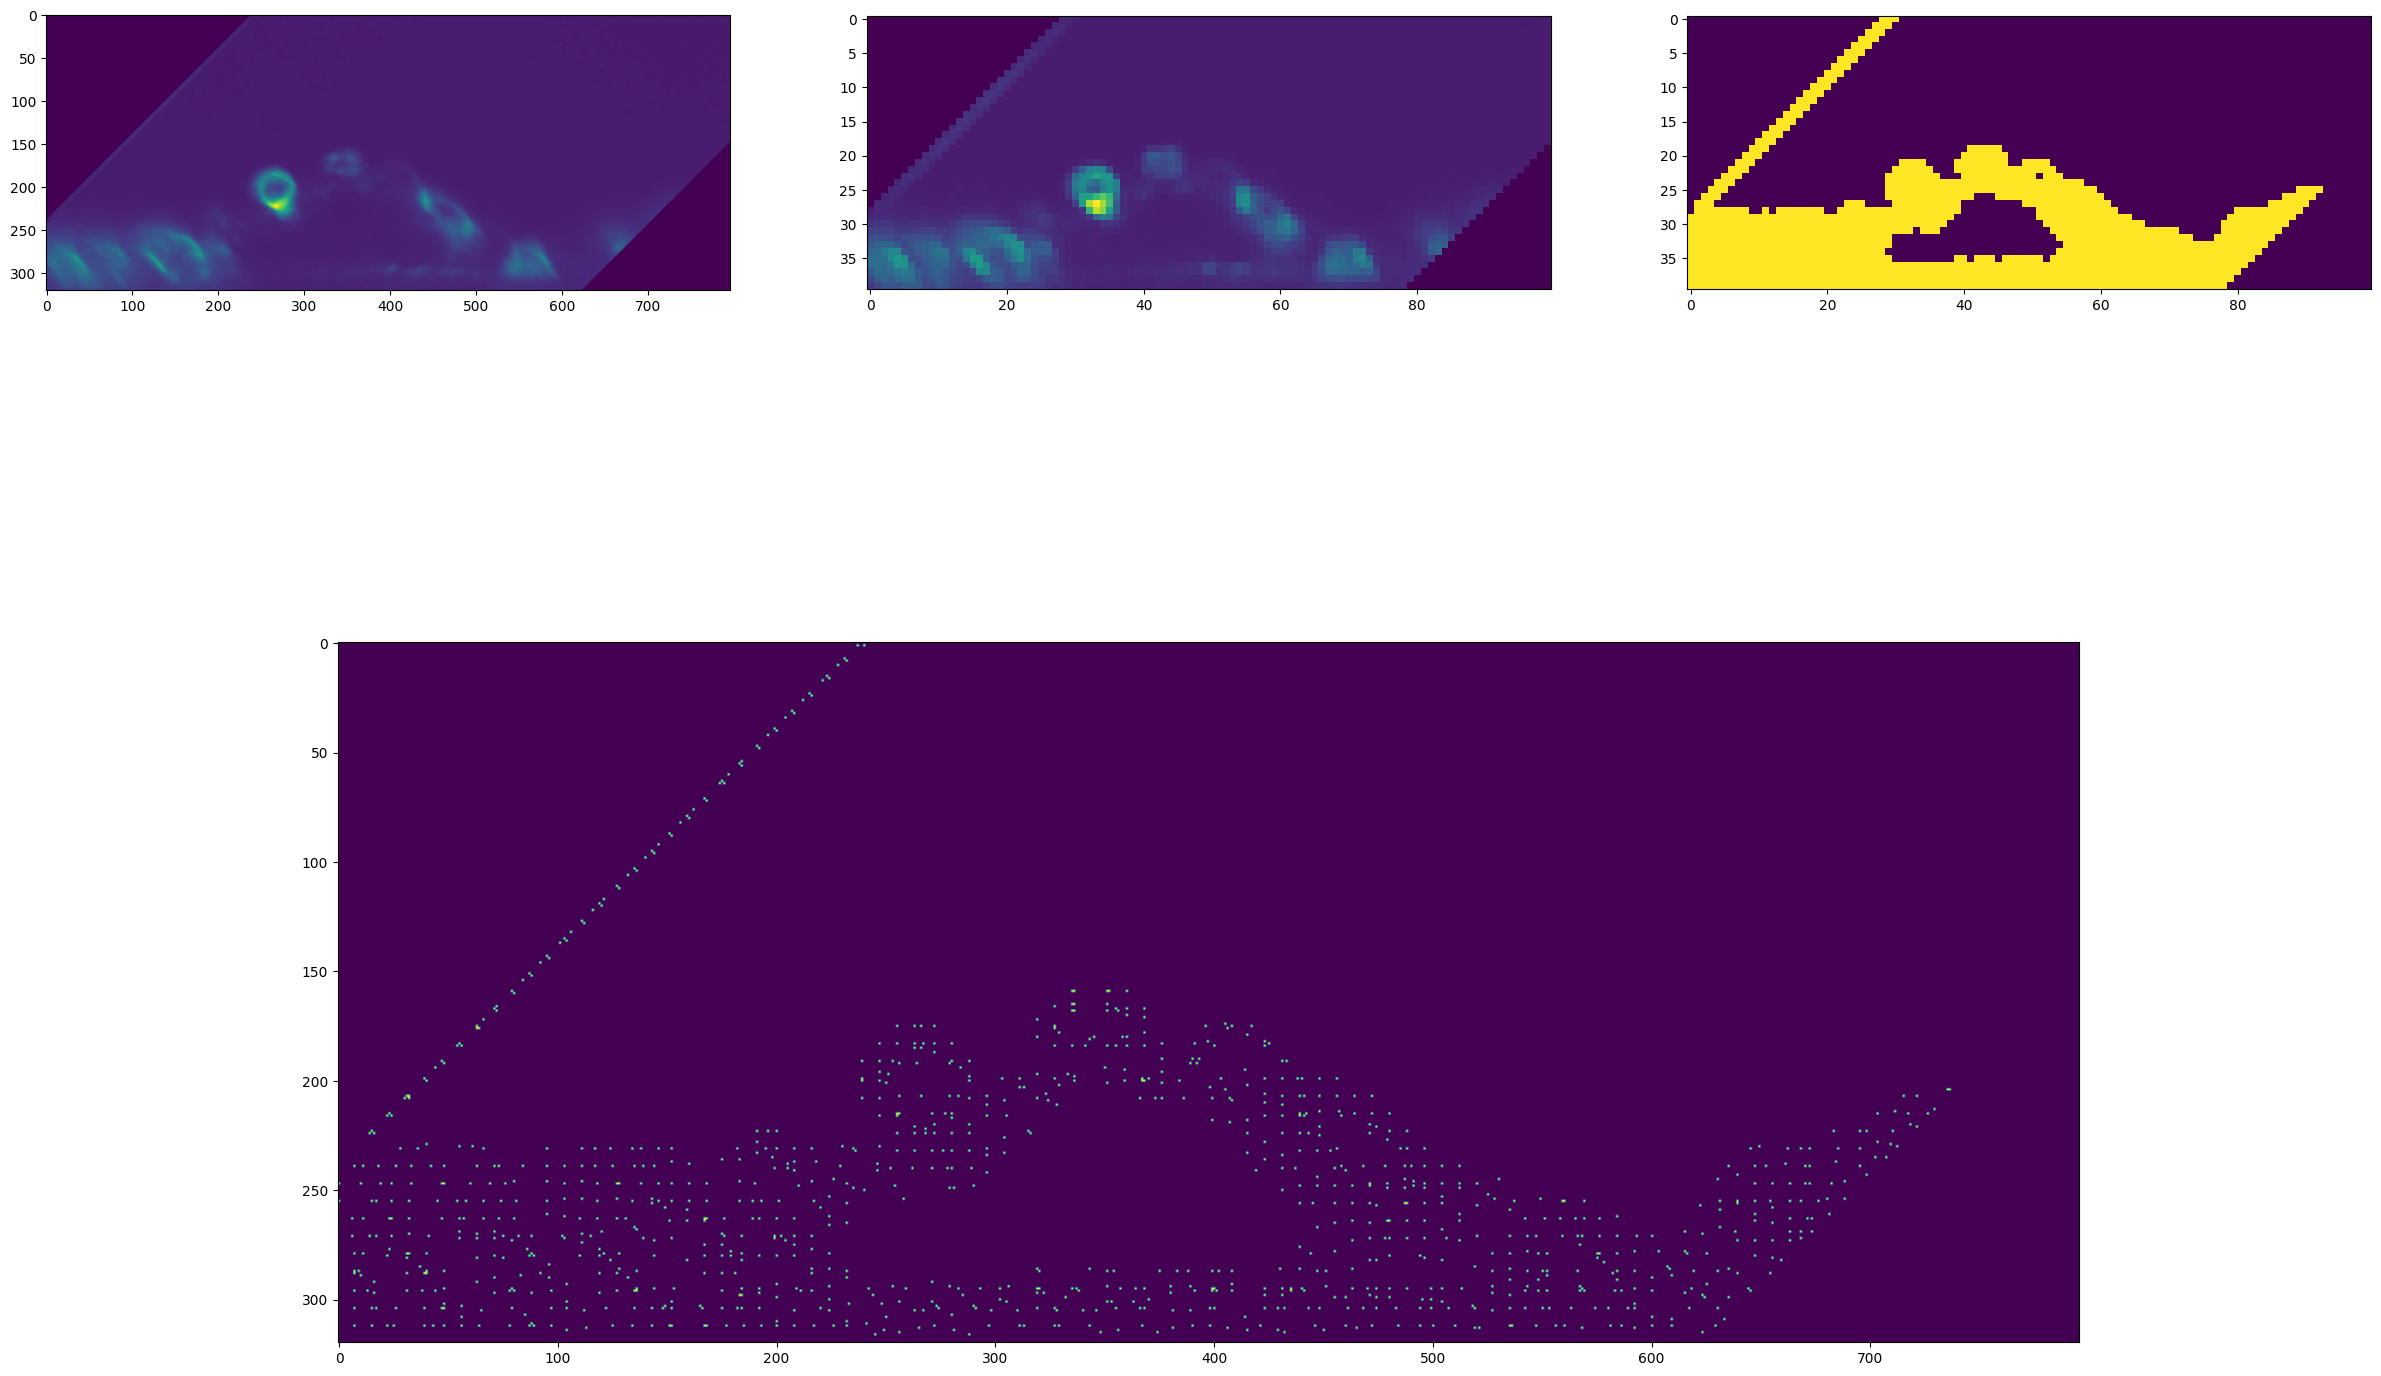

In [93]:
def poolAndMax(input, pool=(2,2), v=False):
    shapeY, shapeX = input.shape[0], input.shape[1] # Original shape of the image

    if shapeY % pool[0] != 0: # If the image Y dimension is not even
        input=np.vstack((input, np.zeros(input.shape[1]))) # Add a zero's row at the bottom
    if shapeX % pool[1] != 0: # If the image X dimension is not even
        input = np.hstack((input, np.zeros((input.shape[0], 1)))) # Add a zero's col at the right

    shapeY, shapeX = input.shape[0], input.shape[1] # Recompute the shape (new shape)
    newY, newX = int(shapeY/2), int(shapeX/2) # The new dimensions that the image will have
    # print(shapeY, shapeX, newY, newX)
    poolList = []
    maxList = [[0 for _ in range(newX)] for _ in range(newY)]
    print(f"Convolution from {shapeY} {shapeX} to {len(maxList)} {len(maxList[0])}") if v else None


    for y in range(0, shapeY, pool[0]):
        for x in range(0, shapeX, pool[1]):
            patch = input[y:y+pool[0], x:x+pool[1]]
            poolList.append(patch.max())
            
            indices = np.unravel_index(np.argmax(patch), patch.shape)
            maxList[int(y / pool[0])][int(x / pool[1])] = (y + indices[0], x + indices[1])
            
    poolArray = np.array(poolList)
    poolArray = np.reshape(poolArray, (newY, newX))
    maxList = np.array(maxList)
    
    return poolArray, maxList



def deconv(input, maxList, pool=(2,2), v=False):
    shapeY, shapeX = maxList.shape[0], maxList.shape[1]
    newY, newX = int(maxList.shape[0]*2), int(maxList.shape[1]*2)
    print(f"Deconvolution from {shapeY} {shapeX} to {newY} {newX}") if v else None
    
    output = [[0 for _ in range(newX)] for _ in range(newY)]

    for y in range(0, shapeY):
        for x in range(0, shapeX):
            indices = maxList[y, x]
            output[indices[0]][indices[1]] = input[y, x]
    
    output = np.array(output)

    return output


plt.figure(figsize=(30,20))

plt.subplot(231)
plt.imshow(image[z])

pool1, maxList1 = poolAndMax(image[z])
pool2, maxList2 = poolAndMax(pool1)
pool3, maxList3 = poolAndMax(pool2)
plt.subplot(232)
plt.imshow(pool3)


mean =  pool3.mean()
pooled_mask = copy.copy(pool3)
pooled_mask[pool3 > mean] = 255
pooled_mask[pool3 <= mean] = 0
plt.subplot(233)
plt.imshow(pooled_mask)


deconv1 = deconv(pooled_mask, maxList3)
deconv2 = deconv(deconv1, maxList2)
deconv3 = deconv(deconv2, maxList1)
plt.subplot(212)
plt.imshow(deconv3)


In [98]:
def poolDeconv3D(image3D, v=False):
    dots3D = []
    c = 1
    for i in image3D:
        pool1, maxList1 = poolAndMax(i)
        pool2, maxList2 = poolAndMax(pool1)
        pool3, maxList3 = poolAndMax(pool2)

        mean =  pool3.mean()
        pooled_mask = copy.copy(pool3)
        pooled_mask[pool3 > mean] = 255
        pooled_mask[pool3 <= mean] = 0

        deconv1 = deconv(pooled_mask, maxList3)
        deconv2 = deconv(deconv1, maxList2)
        deconv3 = deconv(deconv2, maxList1)

        dots3D.append(deconv3)

        print(f"{c}/{image3D.shape[0]}", end="\r") if v else None
        c+=1

    dots3D = np.array(dots3D)

    return dots3D



dots3D = poolDeconv3D(image, v=True)

    



    

KeyboardInterrupt: 

# Second approach

This will be more of a U-Net thing. Convolution and channel growth

In [47]:
def convolve(input):
    if input.ndim == 3:
        inp = input[:, :, 1]
    elif input.ndim == 2:
        inp = input

    filters = [
        [[-1, -2, -1], [0, 0, 0], [1, 2, 1]],
        [[1, 2, 1], [0, 0, 0], [-1, -2, -1]],
        [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
        [[1, 0, -1], [2, 0, -2], [1, 0, -1]],
        [[0, -1, 0], [-1, 5, -1], [0, -1, 0]],
        [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
    ]
    outputs = [ndimage.convolve(input=inp, weights=k, mode='constant', cval=0.0) for k in filters]
    output = np.dstack([input] + outputs)
    
    return output

def poolAndMax(input, pool=(2,2)):
    shapeY, shapeX = input.shape[0], input.shape[1]
    newY, newX = int(shapeY/2), int(shapeX/2)
    # print(shapeY, shapeX, newY, newX)
    poolList = []
    maxList = [[0 for _ in range(newY)] for _ in range(newX)]
    # print(len(maxList))
    for y in range(0, shapeY, pool[0]):
        for x in range(0, shapeX, pool[1]):
            patch = input[y:y+pool[0], x:x+pool[1]]
            poolList.append(patch.max())            
            indices = np.unravel_index(np.argmax(patch), patch.shape)
            # print(int(y / pool[0]), int(x / pool[1]), y + indices[0], x + indices[1])
            maxList[int(y / pool[0])][int(x / pool[1])] = (y + indices[0], x + indices[1])
            
    poolArray = np.array(poolList)
    poolArray = np.reshape(poolArray, (newY, newX))
    maxList = np.array(maxList)
    
    return poolArray, maxList

def pool(input):
    output = []
    outputs = []
    maxLists = []
    for i in range(input.shape[2]):
        inp = input[:, :, i]
        pool_result, maxList = poolAndMax(inp)
        outputs.append(pool_result)
        maxLists.append(maxList)

    output = np.dstack(outputs)

    return output, maxLists



conv1 = convolve(im)
pool1, _ = pool(conv1)
conv2 = convolve(pool1)
pool2, _ = pool(conv2)
conv3 = convolve(pool2)
pool3, _ = pool(conv3)

print(conv1.shape, pool1.shape, conv2.shape, pool2.shape, conv3.shape, pool3.shape)



(256, 256, 7) (128, 128, 7) (128, 128, 13) (64, 64, 13) (64, 64, 19) (32, 32, 19)


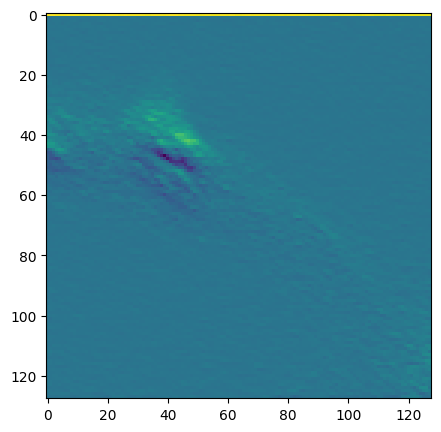

In [68]:
plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(conv2[:, :, 2])